# SKYNET_AI - Detection and Classification of Heart Arrhythmia

#### Group members (names and BU email addresses)

1. Jaseel Muhammed (s5229081@bournemouth.ac.uk)
2. Abhay Sujala Krishnan (s5229584@bournemouth.ac.uk)
3. Josiah Thomas Babu (s5228753@bournemouth.ac.uk)


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import requests
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, average_precision_score,recall_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
from keras.optimizers import Adam
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [33]:
# Distribution graphs (histogram/bar graph) of column data

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [34]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [3]:
#Setting  the data set directory
print(os.listdir(r"dataset/"))

['mitbih_test.csv', 'mitbih_train.csv', 'ptbdb_abnormal.csv', 'ptbdb_normal.csv']


In [4]:
#import the data sets
train_mit=pd.read_csv('dataset/mitbih_train.csv',header=None)
test_mit=pd.read_csv('dataset/mitbih_test.csv',header=None)
ptb_n=pd.read_csv('dataset/ptbdb_normal.csv',header=None)

In [5]:
train_mit.info()
test_mit.info()
ptb_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 5.8 MB


	
# The Dataset
This dataset is composed of two collections of heartbeat signals derived from, the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. All the .CSV files have been downloaded from Kaggle. Each row is an example with the final element of each row representing the class.
 
Here the classes correspond to
   * 0 - Normal ECG
   * 1 - Supraventricular Ectopic ECG
   * 2 - Ventricular Ectopic ECG
   * 3 - Fusion Beats 
   * 4 - Unknown
   

Our Datasets can be downloaded from the following Platforms : 
#### Kaggle:
https://www.kaggle.com/shayanfazeli/heartbeat
####  Microsoft OneDrive:
https://livebournemouthac-my.sharepoint.com/:f:/g/personal/s5229081_bournemouth_ac_uk/EtYqzELpXPNPpml54wI886ABRhlk2M_4bVzHoBlrMgt8zw?e=FsahLW

#### Alternatively it can be found on Google Drive:
https://drive.google.com/drive/folders/1HDa7E0jLDAH8auqoTy0SCi_bEj497P8u?usp=sharing

In [6]:
#Shows the classes stored in 187 index of ptb dataset with count for each
# the ptb data set contains only normal class
ptb_n[187]=ptb_n[187].astype(int)
ptb_normal_class=ptb_n[187].value_counts()
print(ptb_normal_class)

0    4046
Name: 187, dtype: int64


### DATASET ANALYSIS

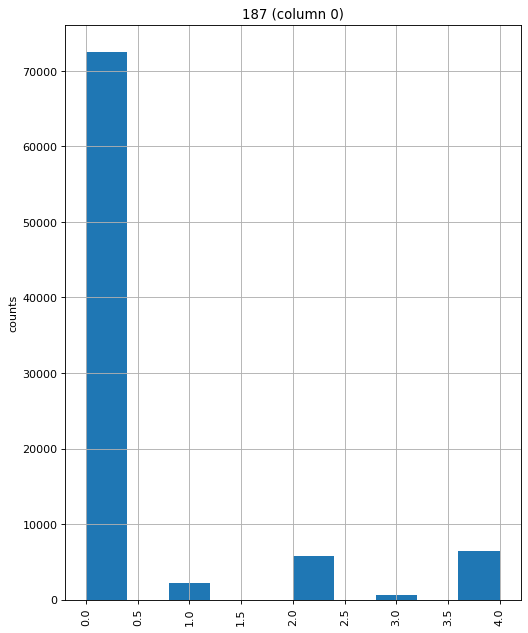

In [45]:
plotPerColumnDistribution(train_mit, 5, 5)

The plot shown above that the dataset is quite unbalanced.There are very few data for classes 1, 2 and 3, where as class 1 is about 90% of the total dataset.

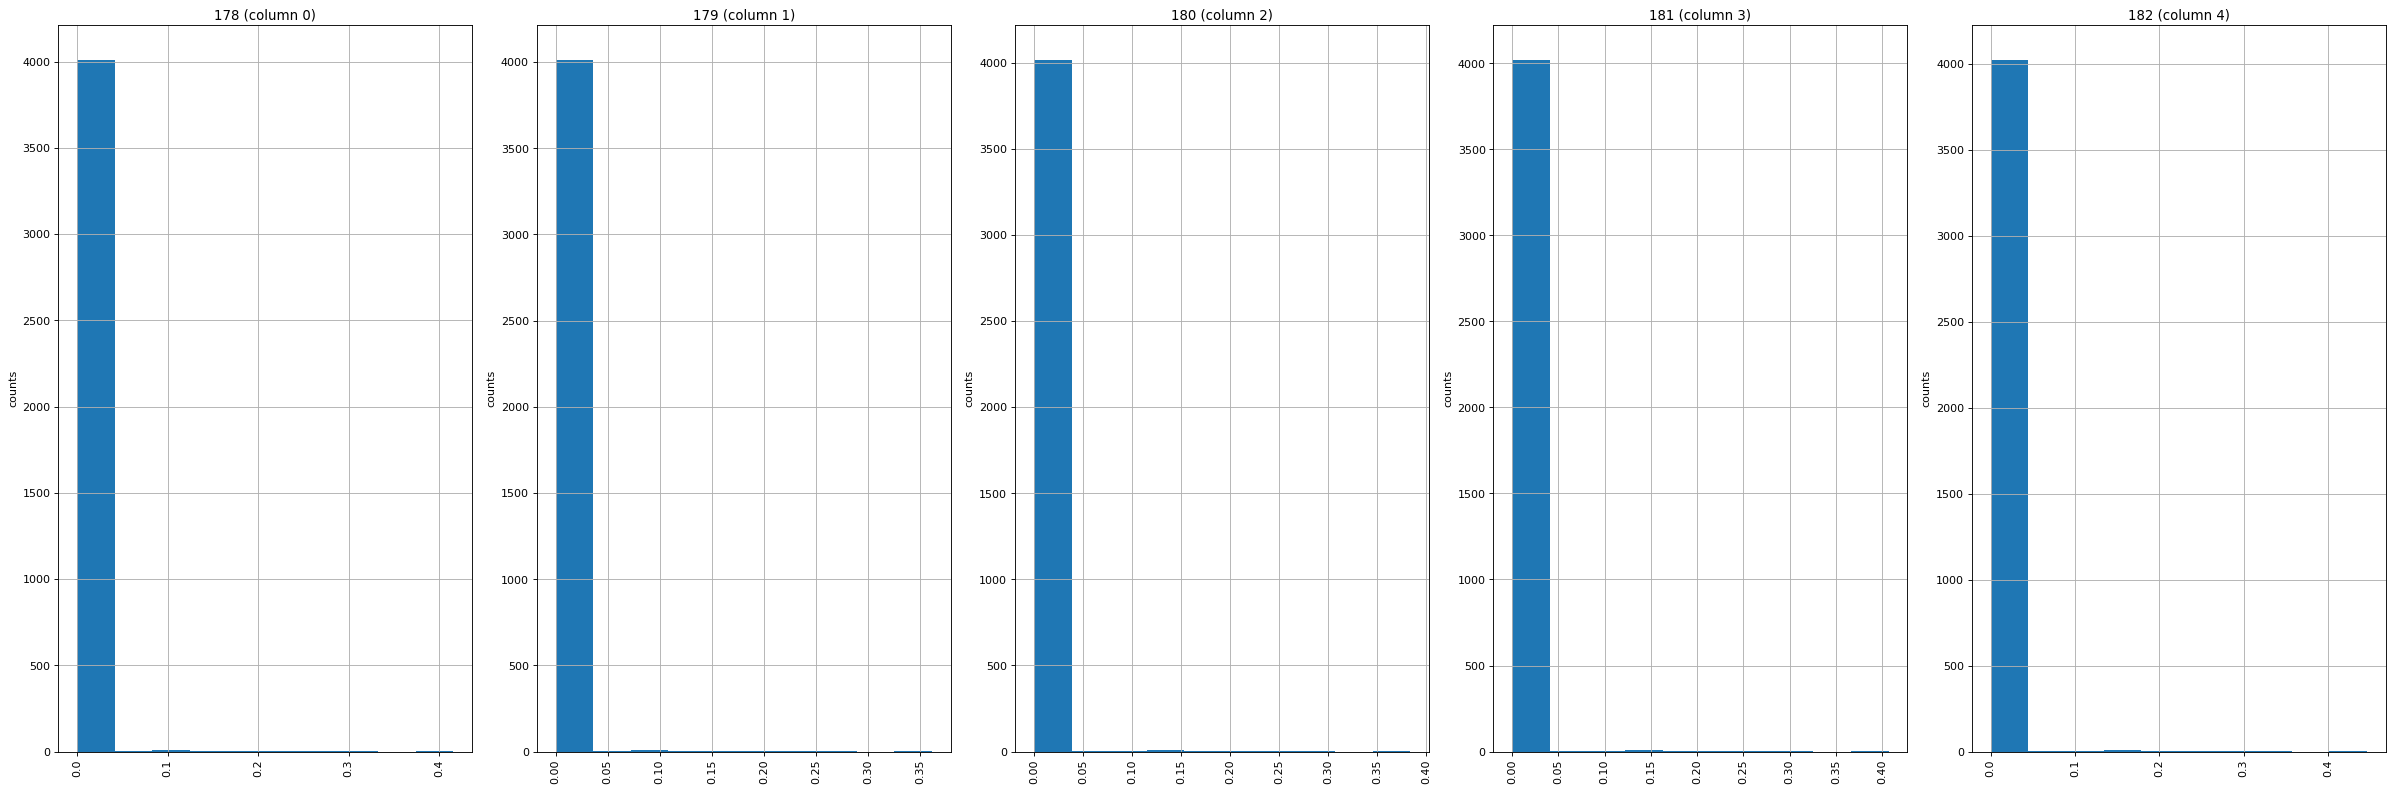

In [50]:
plotPerColumnDistribution(ptb_n, 5, 5)

This second dataset is also unbalanced 

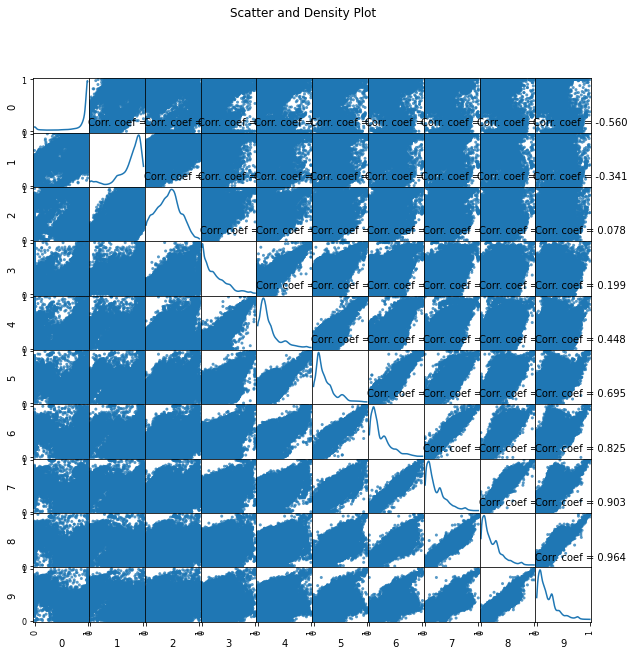

In [51]:
plotScatterMatrix(train_mit, 10, 10)

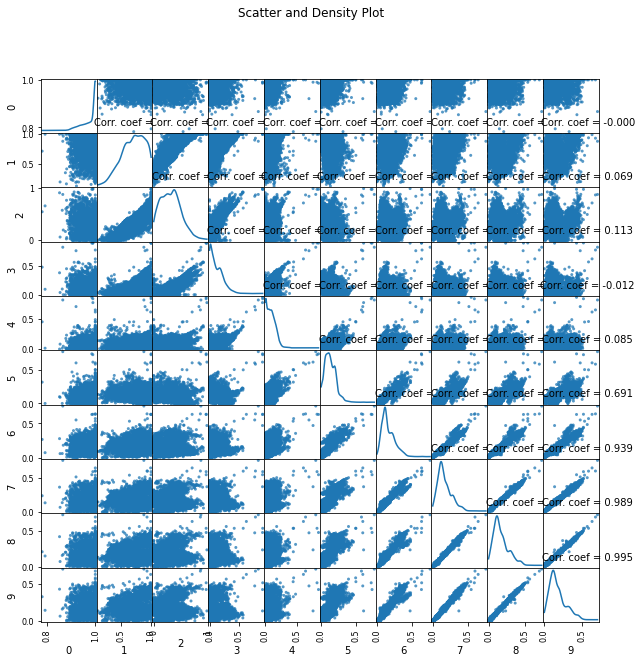

In [49]:
plotScatterMatrix(ptb_n, 10, 10)

Both dataset has strong linear correlation

In [7]:
#Shows the classes stored in 187 index of mit dataset with count for each
#here there are 5 classes
train_mit[187]=train_mit[187].astype(int)
mit_train_classes=train_mit[187].value_counts()
print(mit_train_classes)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [8]:
#Shows the classes stored in 187 index of mit dataset with count for each
#here there are 5 classes
test_mit[187]=test_mit[187].astype(int)
mit_test_classes=test_mit[187].value_counts()
print(mit_test_classes)

0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


In [9]:
# Combining train, test and normal_ptb datasets to shuffle manually
comb_ds=pd.concat([train_mit, test_mit, ptb_n], axis=0)

#the classes stored in 187 index of combined dataset
comb_ds[187]=comb_ds[187].astype(int)
train_comb_classes=comb_ds[187].value_counts()
print(train_comb_classes)

0    94635
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64


In [10]:
#Now to split the dataset into Train, Validate , adn test
#shuffle with  80% 10% 10% split
train, validate, test = np.split(comb_ds.sample(frac=1), [int(.8*len(comb_ds)), int(.9*len(comb_ds))])

In [11]:
#prints a sample from the test database for each class
each_sample=train.groupby(187,group_keys=False).apply(lambda train : train.sample(1))
each_sample

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
6627,0.964615,0.803077,0.410769,0.116923,0.010769,0.109231,0.156923,0.112308,0.106154,0.107692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
72800,0.937759,1.000000,0.394191,0.033195,0.103734,0.182573,0.170124,0.161826,0.232365,0.228216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
18965,0.979592,1.000000,0.809949,0.429847,0.269133,0.241071,0.184949,0.160714,0.174745,0.176020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
20270,1.000000,0.998016,0.668651,0.386905,0.210317,0.138889,0.113095,0.101190,0.085317,0.085317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
82606,0.988971,0.558824,0.595588,0.610294,0.602941,0.573529,0.555147,0.466912,0.323529,0.183824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


Text(0.5, 0, 'Time')

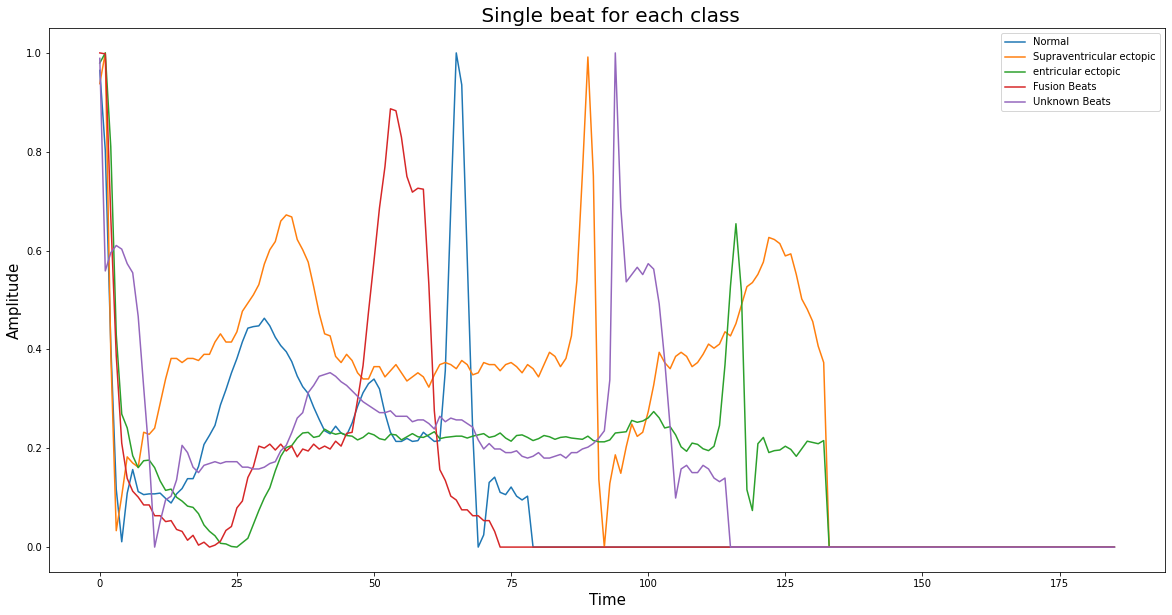

In [12]:
 #plot normal Ecg 
plt.figure(figsize=(20,10))
plt.plot(each_sample.iloc[0,:186],label='Normal')
# plot Supraventricular Ectopic ECG 
plt.plot(each_sample.iloc[1,:186],label='Supraventricular ectopic')
# plot Ventricular Ectopic ECG
plt.plot(each_sample.iloc[2,:186],label='entricular ectopic')
# plot Fusion ECG
plt.plot(each_sample.iloc[3,:186],label='Fusion Beats')
# plot an unknown ECG
plt.plot(each_sample.iloc[4,:186],label='Unknown Beats')
plt.legend()
plt.title(" Single beat for each class", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time", fontsize=15)

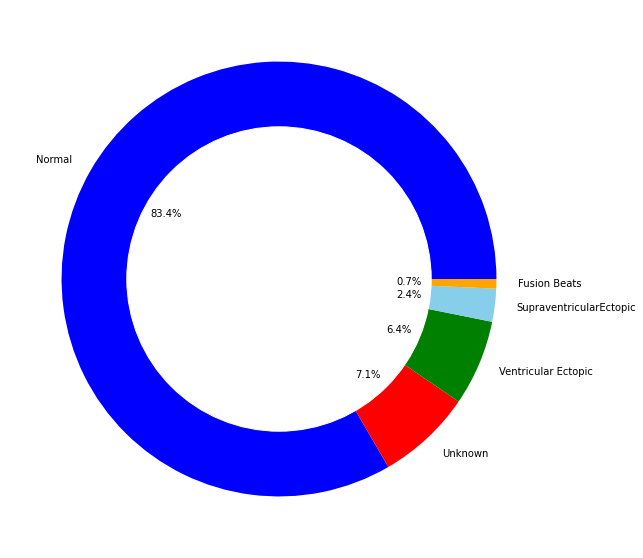

In [13]:
#the classes stored in 187 index of test dataset with count
train[187]=train[187].astype(int)
train_classes=train[187].value_counts()

#ploting a chart of the test database
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train_comb_classes, labels=['Normal','Unknown','Ventricular Ectopic','SupraventricularEctopic','Fusion Beats'], colors=['blue','red','green','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Random Over-Sampling
The above chart shows that the classes are very unbalanced. A way to fight this issue is by generating new samples from the classes which are under-represented. The most naive strategy is to generate new samples by randomly sampling with replacement the current available samples. 

In [21]:
#Random Oversampling Imbalanced Datasets using resaple from slearn
from sklearn.utils import resample

#split the data set based on different classes
normal_over=(train[train[187]==0]).sample(n=10000,random_state=52)

#split class 1
a=train[train[187]==1]
#random resample and add into dataset
a_over=resample(a,replace=True,n_samples=10000,random_state=23)

b=train[train[187]==2]
b_over=resample(b,replace=True,n_samples=10000,random_state=24)

c=train[train[187]==3]
c_over=resample(c,replace=True,n_samples=10000,random_state=25)

d=train[train[187]==4]
d_over=resample(d,replace=True,n_samples=10000,random_state=26)

#combine the balanced resampled classes
train_ovr=pd.concat([normal_over,a_over,b_over,c_over,d_over])

In [22]:
#classes are balanced
Oversampled_classes=train_ovr[187].value_counts()
print(Oversampled_classes)

4    10000
3    10000
2    10000
1    10000
0    10000
Name: 187, dtype: int64


In [23]:
#seperate class identifier from last column and store as new array
class_train=train_ovr[187]
y_train=to_categorical(class_train)
#remove last column
X_train=train_ovr.iloc[:,:186].values

#setting input dimension for keras input
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)


#same for training dataset

class_val=validate[187]
y_val=to_categorical(class_val)
X_val=validate.iloc[:,:186].values
X_val = X_val.reshape(len(X_val), X_val.shape[1],1)


#and test dataset
class_test=test[187]
y_test=to_categorical(class_test)
X_test=test.iloc[:,:186].values
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

## Network

Now datasets are to be trained on the CNN . there are a total of 4 1-D CNN layers. 1st layer has 64 kernals and size 6. the 2nd and 3rd layer each have 64 kernals and size of 3. finally last convolutional layer has 32 kernals and size 3. A maxpooling size of 4 and stride of 2 in the 1st pooling layer and size of 3 and stride of 2 in the 2nd and 3rd pooling layers. the last pooling layer has as size of 3 and stride of 1. Each convolutional layer is normalised before the pooling layer. then it has 2 fully connected dense layers with 64 and 32 neurons and
a soft max layer to predict the output class

In [24]:
K.clear_session()

In [25]:
#initialize the variouos layers of the model
in_shape=(X_train.shape[1],1)

in_cnn=Input(shape=(in_shape), name='in_cnn')
# create layers based on arXiv:1805.00794

#1st convolutional layer
C11=Convolution1D(64, (6), activation='relu', strides=1, input_shape=in_shape)(in_cnn)
#normalizing outputs from the previous convolutional layer
C11=BatchNormalization()(C11)
#downsample the input
M1=MaxPool1D(pool_size=(4), strides=(2), padding="same")(C11)

#2nd convolutional layer   
C21=Convolution1D(64, (3), activation='relu', strides=1, input_shape=in_shape)(M1)

C21=BatchNormalization()(C21)

M2=MaxPool1D(pool_size=(3), strides=(2), padding="same")(C21)

#3rd convolutional layer   
C31=Convolution1D(64, (3), activation='relu', strides=1, input_shape=in_shape)(M2)

C31=BatchNormalization()(C31)

M3=MaxPool1D(pool_size=(3), strides=(2), padding="same")(C31)
#4th convolutional layer 
C41=Convolution1D(32, (3), activation='relu', strides=1, input_shape=in_shape)(M3)

C41=BatchNormalization()(C41)

M4=MaxPool1D(pool_size=(3), strides=(1), padding="same")(C41)

#
F1=Flatten()(M4)
D1 = Dense(64, activation='relu')(F1)
D2 = Dense(32, activation='relu')(D1)

main_output = Dense(5, activation='softmax', name='main_output')(D2)


Here a learning rate with an exponentional deacy is used with the Adam Optimizer.

In [26]:
# setting learning rate to exponentially decay 
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [27]:
#opt=keras.optimizers.Adam(learning_rate=0.01)    
#model.compile(optimizer=opt, loss='categorical_crossentropy',metrics = ['accuracy'])


#compile the model
model = Model(inputs= in_cnn, outputs=main_output)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics = ['accuracy'])    
    
callbacks = [EarlyStopping(monitor='val_loss', patience=8),
ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
#prints a summary of the model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_cnn (InputLayer)          (None, 186, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 181, 64)           448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 181, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 91, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 64)            12352     
_________________________________________________________________
batch_normalization_2 (Batch (None, 89, 64)            256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 45, 64)            0   

## Train

The model is trained for 25 epochs with a batch size of 100

In [28]:
#start training 
history=model.fit(X_train, y_train,epochs=25,callbacks=callbacks, batch_size=100,validation_data=(X_val,y_val),verbose=2)
model.load_weights('best_model.h5')

Train on 50000 samples, validate on 11349 samples
Epoch 1/25
 - 30s - loss: 0.2870 - accuracy: 0.8965 - val_loss: 1.9883 - val_accuracy: 0.2056
Epoch 2/25
 - 30s - loss: 0.1376 - accuracy: 0.9508 - val_loss: 0.2487 - val_accuracy: 0.9161
Epoch 3/25
 - 28s - loss: 0.0990 - accuracy: 0.9654 - val_loss: 0.1834 - val_accuracy: 0.9333
Epoch 4/25
 - 33s - loss: 0.0745 - accuracy: 0.9744 - val_loss: 0.1416 - val_accuracy: 0.9516
Epoch 5/25
 - 30s - loss: 0.0600 - accuracy: 0.9792 - val_loss: 0.1550 - val_accuracy: 0.9470
Epoch 6/25
 - 34s - loss: 0.0507 - accuracy: 0.9829 - val_loss: 0.1039 - val_accuracy: 0.9679
Epoch 7/25
 - 32s - loss: 0.0498 - accuracy: 0.9830 - val_loss: 0.1695 - val_accuracy: 0.9448
Epoch 8/25
 - 34s - loss: 0.0401 - accuracy: 0.9868 - val_loss: 0.1688 - val_accuracy: 0.9500
Epoch 9/25
 - 33s - loss: 0.0401 - accuracy: 0.9860 - val_loss: 0.1348 - val_accuracy: 0.9598
Epoch 10/25
 - 27s - loss: 0.0322 - accuracy: 0.9896 - val_loss: 0.1939 - val_accuracy: 0.9490
Epoch 11/

In [128]:
#from arrhythmia classification kernel from kaggle
#evaluates the model
def evaluate_model(history,X_test_in,y_test_in,model):
    scores = model.evaluate((X_test_in),y_test_in, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
#plot epoch vs accuracy and epoch vs loss for training and validation sets    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test_in:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test_in)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

## Test

Now the trained model is evaluated with the test dataset

Accuracy: 96.54%


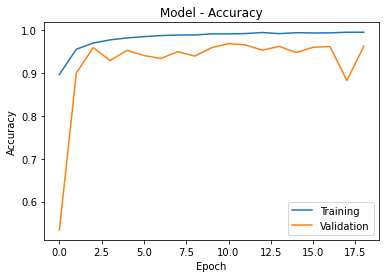

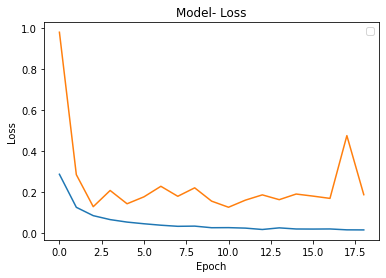

In [123]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test) # predict output from test data set

In [124]:
import itertools

## code for creating confusion Matrix based from arXiv:1805.0079
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Confusion Matrix

Normalized confusion matrix


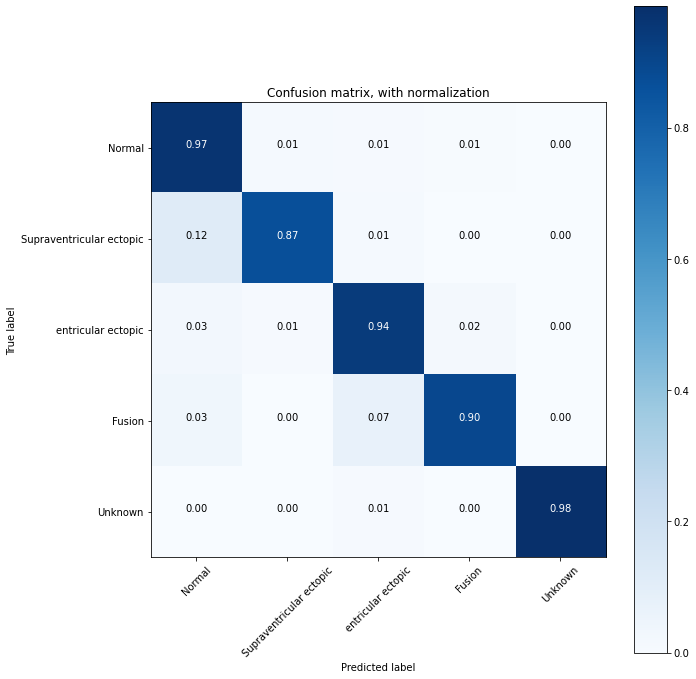

In [125]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Supraventricular ectopic', 'entricular ectopic', 'Fusion', 'Unknown'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [132]:
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.94


# CONCLUSION

The proposed CNN modelling for classification of Arrhythmias using ecg dataset is shown to be effective and efficient. This model is suitable for real time implementation and can be used to diagnose different heart Arrhythmias

# References

Brownlee, J., 2020. A Gentle Introduction To The Rectified Linear Unit (Relu). [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/> [Accessed 3 June 2020].# Reference

Chen, C., Hua, Z., Zhang, R., Liu, G. and Wen, W., 2020. Automated arrhythmia classification based on a combination network of CNN and LSTM. Biomedical Signal Processing and Control, 57, p.101819.

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P.C., Mark, R., Mietus, J.E., Moody, G.B., Peng, C.K. and Stanley, H.E., 2000. PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

Physionet.org. 2020. MIT-BIH Arrhythmia Database V1.0.0. [online] Available at: <https://physionet.org/content/mitdb/1.0.0/> [Accessed 3 June 2020].

Rajpurkar, P. and Hannun, A., 2020. Cardiologist-Level Arrhythmia Detection With Convolutional Neural Networks. [online] Stanfordmlgroup.github.io. Available at: <https://stanfordmlgroup.github.io/projects/ecg/> [Accessed 4 June 2020].